# Welcome to the SAGAN fit tutorial

We are lucky, WFIRST give us a preview event of its work. 
Let's have a look to your choice lightcurve first.

In [1]:
## First import the required libraries
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import time

lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels
from pyLIMA import microlcaustics

In [2]:
### Let's have a look to this event.

WFIRST_data = np.loadtxt('./WFIRST_binary_SAGAN.dat')[::1]

### Lets have a look on what it is exactly :
figure1 = plt.figure()
plt.errorbar(WFIRST_data[:,0]-2460000,WFIRST_data[:,1],yerr = WFIRST_data[:,2],fmt='.k')
plt.gca().invert_yaxis()
figure1.show()


<IPython.core.display.Javascript object>

In [3]:
### First, let's find some properties of the anomaly

## time of the anomaly occurs
t_anomaly = 2460930

## duration of the anomaly.
delta_t = 4.0

## amplitude of the anomaly
delta_I =17.6-16.2

delta_A = 10**((delta_I)/2.5)

In [4]:
### Insert here the parameters you estimated :

to = 2460957.009
uo = 0.4096
tE = 61.232
rho = 0.000464
log_s = -0.13051
log_q = -3.80268
alpha = 0.77975

s = 10**log_s
q = 10**log_q

### Create an event object. You can choose the name and RA,DEC in degrees :

your_event = event.Event()
your_event.name = 'WFIRST binary'

### We define a telescope object.
wfirst = telescopes.Telescope(name='WFIRST', camera_filter='W149', light_curve_magnitude=WFIRST_data)


your_event.telescopes.append(wfirst)

### Let's define a binary model, name in pyLIMA is Uniform Source Binary Lens.

binary_model = microlmodels.create_model('USBL', your_event)
binary_model.define_model_parameters()

### Have a look to your guess. Change these parameters if you want 
estimate_parameters = [to, uo, tE, rho, np.log10(s), np.log10(q), alpha]

pyLIMA_parameters = binary_model.compute_pyLIMA_parameters(estimate_parameters)


model, wfirst_source_flux, wfirst_blend_flux = binary_model.compute_the_microlensing_model(wfirst, pyLIMA_parameters)
model_in_magnitude = 27.4-2.5*np.log10(model)
regime, caustics, cc = microlcaustics.find_2_lenses_caustics_and_critical_curves(10**pyLIMA_parameters.logs,
                                                                                         10** pyLIMA_parameters.logq,
                                                                                        resolution=5000)
reference_telescope = wfirst 
trajectory_x, trajectory_y = binary_model.source_trajectory(reference_telescope,
                                                                    pyLIMA_parameters.to,
                                                                    pyLIMA_parameters.uo,
                                                                    pyLIMA_parameters.tE,
                                                                    pyLIMA_parameters)        


plt.figure()
plt.subplot(211)
plt.errorbar(WFIRST_data[:,0]-2450000,WFIRST_data[:,1],yerr = WFIRST_data[:,2],fmt='.k')
plt.gca().invert_yaxis()
plt.plot(wfirst.lightcurve_flux[:,0]-2450000, model_in_magnitude)
plt.subplot(212)
for count, caustic in enumerate(caustics):
            if caustic != None:
                plt.plot(caustic.real, caustic.imag,lw=3,c='r')
                plt.plot(cc[count].real, cc[count].imag, '--k')

plt.plot(trajectory_x, trajectory_y)
plt.show()

### Now you can modify the estimated parameters to see if you can obtain a better fit.
# Suggested change factor:
#to : +/- 0.1
#uo :  * [0.95,1.05]
#tE : +/- 1
#rho : * [0.95,1.05]
#log_s : * [0.95,1.05]
#log_q : * [0.95,1.05]
#alpha : +/- 0.1

<IPython.core.display.Javascript object>

In [5]:
### Let's fit with a Point Source Point Lens model

### We delete the anomaly for this first fit
good = np.where((WFIRST_data[:,0]<t_anomaly-delta_t) | 
                (WFIRST_data[:,0]>t_anomaly+delta_t))[0]


WFIRST_data_reduce = WFIRST_data[good]

### Plot reject/accept data


wfirst = telescopes.Telescope(name='WFIRST', camera_filter='W149', light_curve_magnitude=WFIRST_data_reduce)

your_event.telescopes[0] = wfirst

pspl_model = microlmodels.create_model('PSPL', your_event)
your_event.fit(pspl_model,'LM')
your_event.fits[0].produce_outputs()
plt.show()


Start fit on WFIRST binary, with model PSPL and method LM
check_event  : Everything looks fine, this event can be fitted
initial_guess  : Initial parameters guess SUCCESS
lmarquardt  : Levenberg_marquardt fit SUCCESS
[2460956.853308085, 0.4235797108967089, 60.14808984201651, 5443.201770739473, -0.04720545959255119, 20176.592710352452]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
### DO NOT USE THIS PART, EXCEPT IF YOU NOT CONFIDENT WITH YOUR PARAMETERS ESTIMATIONS. IN THIS CASE, UNCOMMENT 
### LINES STARTING WITH ONE # 

### Finally, extract PSPL parameters from first fit 
#to = your_event.fits[0].outputs.fit_parameters.to
#uo = your_event.fits[0].outputs.fit_parameters.uo
#tE = your_event.fits[0].outputs.fit_parameters.tE

#U_peak  = (uo**2+(t_anomaly-to)**2/tE**2)**0.5



### Let's have s, rho, q and alpha

###Major image deviation
#s = np.abs((U_peak+(U_peak**2+4)**0.5)/2)
###Minor image deviation
#s = np.abs((U_peak-(U_peak**2+4)**0.5)/2)


#q = (delta_t/(2*tE))**2

#rho = delta_t/(2*tE)


#x_caustic = s-1/s

#if s<1 :
    
#    y_caustic = 2*q**0.5/(s*(1+s**2)**0.5)
    
#else : 
    
#    y_caustic = 0
    
#gamma = np.arccos(uo/U_peak)
#beta = np.arcsin(y_caustic/x_caustic)

#alpha = (np.pi/2-gamma-beta) 


# Geometrical consideration
#if s<1 :
    
#    if t_anomaly > to:
        
#        alpha = np.pi-alpha
#else :
    
#    if t_anomaly > to:
#        alpha = -alpha
        
#    else :
#        alpha = alpha-np.pi
        


Start fit on WFIRST binary, with model USBL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 36913.9
differential_evolution step 2: f(x)= 36913.9
differential_evolution step 3: f(x)= 36913.9
differential_evolution step 4: f(x)= 36913.9
differential_evolution step 5: f(x)= 36913.9
differential_evolution step 6: f(x)= 36913.9
differential_evolution step 7: f(x)= 36913.9
differential_evolution step 8: f(x)= 36903.7
differential_evolution step 9: f(x)= 36881.4
differential_evolution step 10: f(x)= 36881.4
differential_evolution step 11: f(x)= 36881.4
differential_evolution step 12: f(x)= 36875.8
differential_evolution step 13: f(x)= 36875.8
differential_evolution step 14: f(x)= 36875.8
differential_evolution step 15: f(x)= 36867.8
differential_evolution step 16: f(x)= 36835.3
differential_evolution step 17: f(x)= 36835.3
differential_evolution step 18: f(x)= 36833.7
differential_evolution step 19: f(x)= 36833.7
differential_

<IPython.core.display.Javascript object>


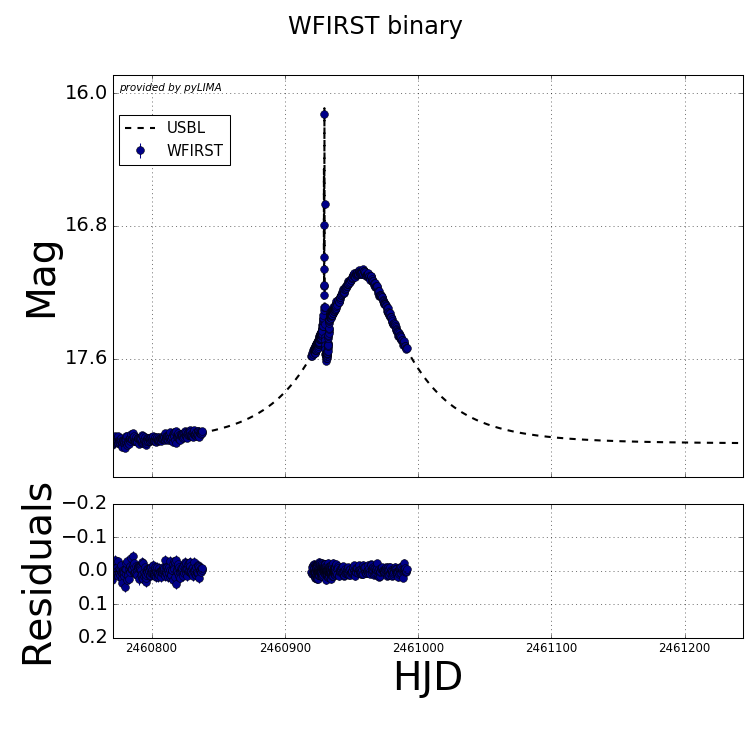

<IPython.core.display.Javascript object>


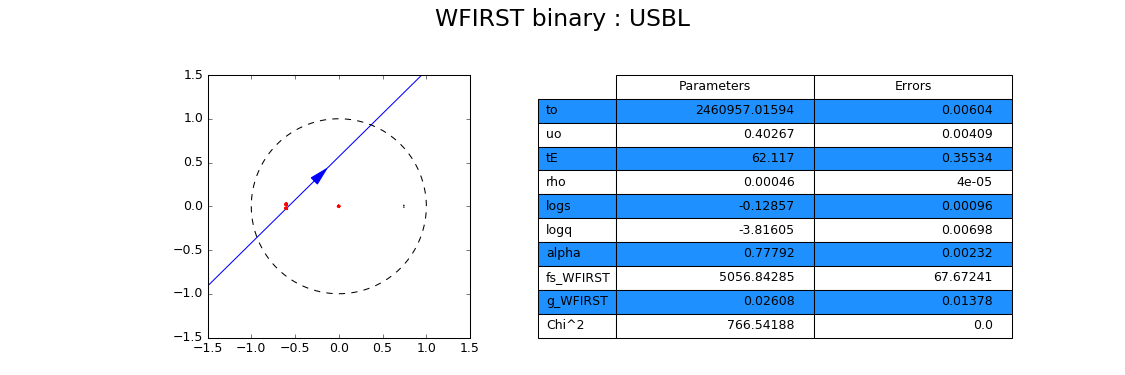

In [10]:
### we redfine our event for the final fit. 
your_event = event.Event()
your_event.name = 'WFIRST binary'


### Speed up computations

## we limited high computations only around the anomaly
binary_model.USBL_windows = [t_anomaly-2*delta_t,t_anomaly+2*delta_t]


## we artifically decrease the number of points for speeding up.
## Do not decrease to much the sampling inside your anomaly if it is short.THIS IS CASE SENSITIVE. 
start_anomaly = np.where(WFIRST_data[:,0]<binary_model.USBL_windows[0])[0][-1]
end_anomaly = np.where(WFIRST_data[:,0]>binary_model.USBL_windows[1])[0][0]

light_curve_reduce = np.r_[WFIRST_data[:start_anomaly:32],
                           WFIRST_data[start_anomaly:end_anomaly:8],
                           WFIRST_data[end_anomaly::32]]

#int(delta_t/2+1)
wfirst = telescopes.Telescope(name='WFIRST', camera_filter='W149', light_curve_magnitude=light_curve_reduce)

your_event.telescopes.append(wfirst)



### to boundaries
binary_model.parameters_boundaries[0] = [to-3,to+3]
### uo boundaries
binary_model.parameters_boundaries[1] = [uo-0.1 , uo+0.1]
### tE boundaries
binary_model.parameters_boundaries[2] = [tE-2,tE+2]
### rho boundaries
binary_model.parameters_boundaries[3] = [10**-4,10**-2]
### log_10(s) boundaries
binary_model.parameters_boundaries[4] = [np.log10(s)-0.5,np.log10(s)+0.5]
### log_10(q) boundaries
#binary_model.parameters_boundaries[5] = [-5.60,-3.60]
### alpha boundaries
binary_model.parameters_boundaries[6] = [alpha-1.0,alpha+1.0]

### DE_population_size scale the size of the DE population. More it is, bigger is your chance to find the minima
### but slower it is.
start = time.time()

your_event.fit(binary_model, 'DE',  DE_population_size = 4)
print time.time()-start

#import pdb; pdb.set_trace()
your_event.fits[-1].produce_outputs()
plt.show()